In [ ]:
def masterProblemNew(A1,net):
    cap = {}
    capacity = {}
    for g in net.G.edges:
        ix = net.edgesLableDictReverse[g]
        cap[ix]=net.edgeStatistics.minPossibleFlow[g]
        capacity[ix]=cap[ix]*(1-A1[ix])
    
    pa = net.pathEdgeIncidence
    mp=gu.Model("primal")

    paa , p  = gu.multidict(pa.stack())
    x= mp.addVars(pa.index)
    constraintPrimal = mp.addConstrs(gu.quicksum(p[i,j]*x[i] for i in pa.index)<=capacity[j] for j in pa.columns)
    mp.setObjective(gu.quicksum(x[i] for i in pa.index), gu.GRB.MAXIMIZE)
    mp.setParam('LogToConsole', 0)
    mp.optimize()

    pi = {}
    slack = {}
    
    for l,m in constraintPrimal.items():
        pi[l]= m.PI
        slack[l] = m.slack
    primal = {}
    for l,m in x.items():
        primal[l]= m.x
    return {"dual": pd.Series(pi) , "primal": pd.Series(primal), "slack": pd.Series(slack), "obj": mp.objVal}

def subProblemNew(pi,net,k):
    
    msub=gu.Model("subproblem")

    x_sub = msub.addVars(net.pathEdgeIncidence.columns, vtype = gu.GRB.BINARY)
    msub.addConstr(x_sub.sum('*')==k)
    msub.setObjective(gu.quicksum(x_sub[j]*pi[j] for j in net.pathEdgeIncidence.columns), gu.GRB.MAXIMIZE)
    msub.setParam('LogToConsole', 0)
    msub.optimize()

    A1 = {}
    for k,v in x_sub.items():
        A1[k]=v.x

    return {"pattern": A1, "obj": msub.objVal}

def iterationMasterSub(net,iterNumber, k,results):
    if iterNumber == 1:
        A,_ =  getInitialColumn(net,k)
    else:
        A = results[net.name]["iter"+str(iterNumber-1)]["sub"]["pattern"]
    master = masterProblemNew(A,net)
    sub = subProblemNew(master["dual"] ,net,k)  
    results[net.name]["iter"+str(iterNumber)] = {"master":master,  "sub":  sub}
    i = str(iterNumber)
    pp = pd.DataFrame({'dual'+i:master["dual"],'slack'+i:master["slack"], 'pattern'+i: A, "patternSub"+i:sub["pattern"]})
    pp1 = pd.concat([results[net.name]["patterns"],pp],axis=1)
    results[net.name]["patterns"] = pp1


In [9]:
from pyvis.network import Network
import pandas as pd
import networkx as nx

from netAnalysis import netAnalysis

net3 = False
if net3:
    net3 = netAnalysis.import_graph_from_excel("net3", header=[0, 1], nodepos=True)
    net3.doAllTheTasks()
net4 = True
if net4 == True:
    net4 = netAnalysis.from_GML_file(os.path.join("networks", "graph20190606_0755.gml"))

Optimize a model with 37 rows, 27 columns and 69 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 37 rows and 27 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.200000000e+01
Optimize a model with 38 rows, 27 columns and 76 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0000000e+31   1.700000e+31   4.000000e+01      0s
       6    2.3900000e+02   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.01 seconds
Optimal objective  2.390000

In [10]:
from pyvis.network import Network
G = Network()
G.from_nx(net4.G)
G.show("mygraph.html")

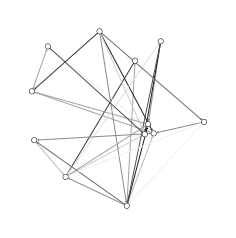

In [16]:
import netgraph
netgraph.draw(net4.G)

C:\Users\User\Anaconda3\lib\site-packages\netgraph\_main.py:857: UserWarning: Plotting of self-loops not supported. Ignoring edge (15, 15).
  warnings.warn("Plotting of self-loops not supported. Ignoring edge ({}, {}).".format(source, target))
C:\Users\User\Anaconda3\lib\site-packages\netgraph\_main.py:857: UserWarning: Plotting of self-loops not supported. Ignoring edge (9, 9).
  warnings.warn("Plotting of self-loops not supported. Ignoring edge ({}, {}).".format(source, target))
C:\Users\User\Anaconda3\lib\site-packages\netgraph\_main.py:857: UserWarning: Plotting of self-loops not supported. Ignoring edge (19, 19).
  warnings.warn("Plotting of self-loops not supported. Ignoring edge ({}, {}).".format(source, target))
C:\Users\User\Anaconda3\lib\site-packages\netgraph\_main.py:857: UserWarning: Plotting of self-loops not supported. Ignoring edge (12, 12).
  warnings.warn("Plotting of self-loops not supported. Ignoring edge ({}, {}).".format(source, target))
C:\Users\User\Anaconda3\li

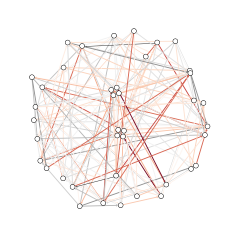

In [13]:
import numpy as np
import matplotlib.pyplot as plt; plt.ion()
import netgraph

# Construct sparse, directed, weighted graph
# with positive and negative edges:
total_nodes = 20
weights = np.random.randn(total_nodes, total_nodes)
connection_probability = 0.2
is_connected = np.random.rand(total_nodes, total_nodes) <= connection_probability
graph = np.zeros((total_nodes, total_nodes))
graph[is_connected] = weights[is_connected]

# Make a standard plot:
netgraph.draw(graph)

# Create an interactive plot.
# NOTE: you must retain a reference to the object instance!
# Otherwise the whole thing will be garbage collected after the initial draw
# and you won't be able to move the plot elements around.
plot_instance = netgraph.InteractiveGraph(graph)

# The position of the nodes can be adjusted with the mouse.
# To access the new node positions:
node_positions = plot_instance.node_positions

In [14]:
import plotly
import plotly.graph_objs as go

plotly.offline.plot({
    "data": [go.Scatter(x=[1, 2, 3, 4], y=[4, 3, 2, 1])],
    "layout": go.Layout(title="hello world")
}, auto_open=True)

'temp-plot.html'

In [15]:
from IPython.display import IFrame
IFrame(src= "https://dash-simple-apps.plotly.host/dash-networkplot/", width="100%", height="650px", frameBorder="0")

In [ ]:
    def minMax(self, k, returnAllLeaves=False):
        startt = time.time()
        edgeGroupList = itertools.combinations(self.G.edges, k)
        faultyEdgeFlow = {}
        start = time.time()
        for edgeGroup in edgeGroupList:
            g = self.G.copy()
            for e in edgeGroup:
                g[e[0]][e[1]]['capacity'] = 0
            faultyEdgeFlow[edgeGroup] = nx.maximum_flow_value(g,
                                                              _s='s',
                                                              _t='t')
        solution = min(faultyEdgeFlow, key=faultyEdgeFlow.get)
        solution1 = [self.edgesLableDictReverse[k] for k in solution]
        endtime = time.time()

        executionTime = endtime - startt

        min_val = faultyEdgeFlow[solution]
        if returnAllLeaves:
            print("return all details")
            alternateSolutions = [k for k, v in faultyEdgeFlow.items() if v == min_val]
            return {"time": executionTime, "solution": solution, "obj": min_val,
                    "faultyEdgeFlow": faultyEdgeFlow, "alternateSolutions": alternateSolutions}
        else:
            return {"time": "{:.4f}".format(executionTime), "solution": solution1, "obj": min_val} 

In [1]:
minKthMinFlow = paper1.edgeStatistics.minPossibleFlow.nlargest(3, keep='all').min()
A_temp= paper1.edgeStatistics.minPossibleFlow.copy()
A_temp[paper1.edgeStatistics.minPossibleFlow<minKthMinFlow]=0
A_temp.index=A_temp.index.values
A_temp = A_temp.sort_values(ascending=False)
A= pd.Series(0, index = paper1.edgeStatistics.index)
A[A_temp.iloc[:k].index]=1


colName = 1
A1=A.iloc[:,colName]
A1=pd.DataFrame(A1)
A1["idx"]=A1.index.to_series().map(edgesRev)
A1 =A1.set_index("idx")
A1 = A1[colName]

NameError: name 'paper1' is not defined

In [ ]:
def getEdgeCapacity(net):
    cap = {}
    for g in net.G.edges:
        ix = net.edgesLableDictReverse[g]
        cap[ix]=net.G.edges[g]['capacity']
    return pd.Series(cap)
c = getEdgeCapacity(p1)
p = p1.pathEdgeIncidence


A, _ = getInitialColumn(p1,2)
dual,primal, slack, obj =  masterProblemNew(A,p1)
A21, objVal2 = subProblemNew(dual,p1,2)
pd.DataFrame({'dual':dual,'slack':slack, 'pattern1': A, "pattern2":A21})

In [2]:
n15.solvefork(2)

1 , _ = getInitialColumn(n1,2)
dual1,primal1, slack1, obj1 =  masterProblemNew(A1,n1)
A211, objVal21 = subProblemNew(dual1,n1,2)
# df = pd.DataFrame({'dual':dual1,'slack':slack1, 'pattern1': A1, "pattern2":A211})
df = pd.DataFrame({'dual':dual1, 'pattern1': A1, "pattern2":A211})

df.loc[list(n1.mm.loc[2].sol.bm),"optimal"]=1
df.fillna(0,inplace=True)
df.loc[~(df==0).all(axis=1)]

SyntaxError: can't assign to literal (<ipython-input-2-7152af4757bb>, line 3)